Implementation of the paper：

- Wong, K.-F. & Wang, X.-J. A Recurrent Network Mechanism 
  of Time Integration in Perceptual Decisions. 
  J. Neurosci. 26, 1314–1328 (2006).

In [1]:
import brainpy as bp
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

print("version：", bp.__version__)

version： 0.3.4


In [144]:
def decision_model1(tau_s=100., gamma=0.641,
                J_rec = .1561, J_inh = .0264,
                J_A11 = 9.9026e-04, J_A12 = 6.5177e-05, 
                I_0=0.2346, noise = 1.,
                tau_A = 2.):
    '''
    Args:
        tau_s (float): NMDAR time constant.
        gamma (float): NMDAR dynamics parameters.
        J_rec (float): from self to self, NMDA; J_N11=J_N22
        J_inh (float): from others to self, NMDA; J_N21=J_N12
        J_A11 (float): from 1 to 1, AMPAR; J_A22=J_A11
        J_A12 (float): from 2 to 1, AMPAR; J_A21=J_A12
        I_0 (float): mean effective external input.
        noise (flaot): variance of the noise.
        ----------
        tau_A (float): AMPAR time constant.
    '''
    ST = bp.types.NeuState('s1', 's2', 'r1', 'r2', 'input1','input2')

    def theta(x):
        return np.where(x< 0, 0, 1)

    def H(x1):
        a = 239400 * J_A11 + 270
        b = 97000 * J_A11 + 108
        d = -30 * J_A11 + 154
        h1 = a * x1 - b
        return h1 / (1 - np.exp(-d * h1))
    
    @bp.integrate
    def int_s1(s1, t, s2, I1):
        x1 = J_rec * s1 - J_inh * s2 + I_0 + I1
        r1 = H(x1)
        dsdt = - s1 / tau_s + (1 - s1) * gamma * r1
        return (dsdt, noise / tau_s), r1

    @bp.integrate
    def int_s2(s2, t, s1, I2):
        x2 = J_rec * s2 - J_inh * s1 + I_0 + I2
        r2 = H(x2)
        dsdt = - s2 / tau_s + (1 - s2) * gamma * r2
        return (dsdt, noise / tau_s), r2

    def update(ST, _t):
        s1, ST['r1'] = int_s1(ST['s1'], _t, ST['s2'], ST['input1'])
        ST['s2'], ST['r2'] = int_s2(ST['s2'], _t, ST['s1'], ST['input2'])
        ST['s1'] = s1
        ST['input1'] = 0.
        ST['input2'] = 0.

    return bp.NeuType(name='neuron', 
                    ST=ST, 
                    steps=update, 
                    mode='scalar')

In [11]:
def decision_model(tau_s=100., gamma=0.641,
                J_rec = .1561, J_inh = .0264,
                J_A11 = 9.9026e-04, J_A12 = 6.5177e-05, 
                I_0=0.2346, noise = 1.,
                tau_A = 2., JAext = .2243e-03):
    '''
    Args:
        tau_s (float): NMDAR time constant.
        gamma (float): NMDAR dynamics parameters.
        J_rec (float): from self to self, NMDA; J_N11=J_N22
        J_inh (float): from others to self, NMDA; J_N21=J_N12
        J_A11 (float): from 1 to 1, AMPAR; J_A22=J_A11
        J_A12 (float): from 2 to 1, AMPAR; J_A21=J_A12
        I_0 (float): mean effective external input.
        noise (flaot): variance of the noise.
        ----------
        tau_A (float): AMPAR time constant.
    '''
    ST = bp.types.NeuState('s1', 's2', 'r1', 'r2', 'input1','input2')

    def theta(x):
        return np.where(x< 0, 0, 1)

    def H(x1):
        a = 239400 * J_A11 + 270
        b = 97000 * J_A11 + 108
        d = -30 * J_A11 + 0.154
        h1 = a * x1 - b
        return h1 / (1 - np.exp(-d * h1))
    
    @bp.integrate
    def int_s1(s1, t, s2, I1):
        I1 = JAext * 30. * (1 + 0.) 
        x1 = J_rec * s1 - J_inh * s2 + I_0 + I1
        #r1 = H(x1)
        a = 239400 * J_A11 + 270
        b = 97000 * J_A11 + 108
        d = -30 * J_A11 + 0.154
        h1 = a * x1 - b
        r1 = h1 / (1 - np.exp(-d * h1))
        dsdt = - s1 / tau_s + (1 - s1) * gamma * r1
        return (dsdt, noise / tau_s), r1

    @bp.integrate
    def int_s2(s2, t, s1, I2):
        I2 = JAext * 30. * (1 + 0.) 
        x2 = J_rec * s2 - J_inh * s1 + I_0 + I2
        #r2 = H(x2)
        a = 239400 * J_A11 + 270
        b = 97000 * J_A11 + 108
        d = -30 * J_A11 + 0.154
        h1 = a * x2 - b
        r2 = h1 / (1 - np.exp(-d * h1))
        dsdt = - s2 / tau_s + (1 - s2) * gamma * r2
        return (dsdt, noise / tau_s), r2

    def update(ST, _t):
        s1, ST['r1'] = int_s1(ST['s1'], _t, ST['s2'], ST['input1'])
        ST['s2'], ST['r2'] = int_s2(ST['s2'], _t, ST['s1'], ST['input2'])
        ST['s1'] = s1
        ST['input1'] = 0.
        ST['input2'] = 0.

    return bp.NeuType(name='neuron', 
                    ST=ST, 
                    steps=update, 
                    mode='scalar')

Simplest form: without AMPA at recurrent synapses (from appendix)

$$ \frac {dS_i}{dt} = - \frac{S_i}{\tau_S} + (1-S_i)\gamma H_i $$

$$ H_i = \frac {a x_i - b}{1-\rm{exp} [-d(ax_i - b)]} $$

$$ x_1 = J_{11} S_1 - J_{12} S_2 +I_0 + I_1 + I_{\rm noise, 1} $$

$$ x_2 = J_{22} S_2 - J_{21} S_1 +I_0 + I_2 + I_{\rm noise, 2} $$

$$ I_i = J_{\rm A, ext} \mu_0 (1 +- c') $$

$$ \tau_{\rm AMPA} \frac {dI_{\rm noise, i}(t)}{dt} = - I_{\rm noise, i}(t) + \eta_i(t) \sqrt{\tau_{\rm AMPA} * \sigma_{\rm noise}^2} $$


where $i=1,2$ labels the selective population. 

Parameter values for the input-output function $H_i$ are $a = 270$(VnC)$^{-1}, b = 108$Hz, and $d = 0.154$s.

The kinetic parameters are $\gamma = 0.641, \tau_s = 100$ms, and $\tau_{\rm AMPA} = 2$ms.

The synaptic couplings are $J_{11} = J_{22} = 0.2609$ nA, $J_{12} = J_{21} = 0.0497$nA, and $J_{\rm A, ext} = 5.2 \times 10^{-4}$nA$\cdot$Hz$^{-1}$.

The overall effective external inputs is $I_0 = 0.3255$nA.

The noise amplitude is $\sigma_{\rm noise} = 0.02$ nA and the stimulus is $\mu_0 = 30$ Hz.

In [129]:
def decision_model2(tau_s=100., gamma=0.641,
                J_rec = .2609, J_inh = .0497, 
                I_0=.3255, noise = .02,
                tau_A = 2.):

    ST = bp.types.NeuState('s1', 's2', 'r1', 'r2', 'input1','input2','noise1', 'noise2')

    def H(x1):
        a = 270
        b = 108
        d = 154
        h1 = a * x1 - b
        return h1 / (1 - np.exp(-d * h1))
    
    @bp.integrate
    def int_Inoise1(Inoise1, t):
        return -Inoise1 / tau_A, np.sqrt(tau_A * noise**2) / tau_A
    
    @bp.integrate
    def int_Inoise2(Inoise2, t):
        return -Inoise2 / tau_A, np.sqrt(tau_A * noise**2) / tau_A
    
    @bp.integrate
    def int_s1(s1, t, s2, I1, I_noise1):
        x1 = J_rec * s1 - J_inh * s2 + I_0 + I1 + I_noise1
        r1 = H(x1)
        dsdt = - s1 / tau_s + (1 - s1) * gamma * r1
        return (dsdt,), r1

    @bp.integrate
    def int_s2(s2, t, s1, I2, I_noise2):
        x2 = J_rec * s2 - J_inh * s1 + I_0 + I2 + I_noise2
        r2 = H(x2)
        dsdt = - s2 / tau_s + (1 - s2) * gamma * r2
        return (dsdt,),r2

    def update(ST, _t):
        s1, ST['r1'] = int_s1(ST['s1'], _t, ST['s2'], ST['input1'], ST['noise1'])
        s2, ST['r2'] = int_s2(ST['s2'], _t, ST['s1'], ST['input2'], ST['noise2'])
        ST['s1'] = s1
        ST['s2'] = s2
        #ST['s1'] = np.clip(s1, 0., 1.)
        #ST['s2'] = np.clip(s2, 0., 1.)
        ST['noise1'] = int_Inoise1(ST['noise1'], _t)
        ST['noise2'] = int_Inoise2(ST['noise2'], _t)
        ST['input1'] = 0.
        ST['input2'] = 0.

    return bp.NeuType(name='neuron', 
                    ST=ST, 
                    steps=update, 
                    mode='scalar')

In [ ]:
def decision_model(tau_s=100., gamma=0.641,
                J_rec = .2609, J_inh = .0497, 
                I_0=.3255, noise = .02,
                tau_A = 2.):

    ST = bp.types.NeuState('s1', 's2', 'r1', 'r2', 'input1','input2','noise1', 'noise2')

    def H(x1):
        a = 270
        b = 108
        d = 154
        h1 = a * x1 - b
        return h1 / (1 - np.exp(-d * h1))
    
    @bp.integrate
    def int_Inoise1(Inoise1, t):
        return -Inoise1 / tau_A, np.sqrt(tau_A * noise**2) / tau_A
    
    @bp.integrate
    def int_Inoise2(Inoise2, t):
        return -Inoise2 / tau_A, np.sqrt(tau_A * noise**2) / tau_A
    
    @bp.integrate
    def int_s1(s1, t, s2, I1, I_noise1):
        x1 = J_rec * s1 - J_inh * s2 + I_0 + I1 + I_noise1
        r1 = H(x1)
        dsdt = - s1 / tau_s + (1 - s1) * gamma * r1
        return (dsdt,), r1

    @bp.integrate
    def int_s2(s2, t, s1, I2, I_noise2):
        x2 = J_rec * s2 - J_inh * s1 + I_0 + I2 + I_noise2
        r2 = H(x2)
        dsdt = - s2 / tau_s + (1 - s2) * gamma * r2
        return (dsdt,),r2

    def update(ST, _t):
        s1, ST['r1'] = int_s1(ST['s1'], _t, ST['s2'], ST['input1'], ST['noise1'])
        s2, ST['r2'] = int_s2(ST['s2'], _t, ST['s1'], ST['input2'], ST['noise2'])
        ST['s1'] = s1
        ST['s2'] = s2
        #ST['s1'] = np.clip(s1, 0., 1.)
        #ST['s2'] = np.clip(s2, 0., 1.)
        ST['noise1'] = int_Inoise1(ST['noise1'], _t)
        ST['noise2'] = int_Inoise2(ST['noise2'], _t)
        ST['input1'] = 0.
        ST['input2'] = 0.

    return bp.NeuType(name='neuron', 
                    ST=ST, 
                    steps=update, 
                    mode='scalar')

I1 = 0.0  I2 = 0.0


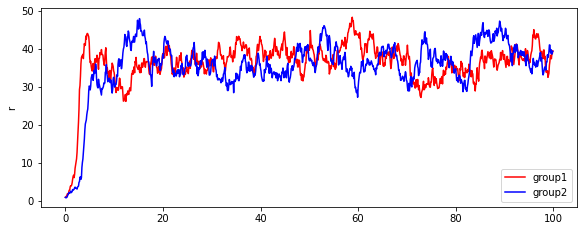

<ipython-input-134-e33e5adadf56>:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_subplot(gs[1, 0])


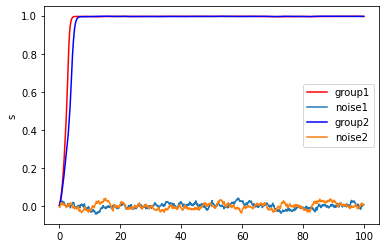

In [134]:
coherence = 0.
mu0 = 0.

I1, I2 = stimulus(coherence, mu0, 1.)
print("I1 =", I1, " I2 =", I2)

model = decision_model(noise=0.02, gamma=.006)
neu = bp.NeuGroup(model, 1, monitors=['s1','s2','r1', 'r2','noise1','noise2'])

neu.run(duration=100., inputs=(['ST.input1', I1],['ST.input2', I2]), report=False)

fig, gs = bp.visualize.get_figure(2, 1, 3, 8)

fig.add_subplot(gs[0, 0])

plt.plot(neu.mon.ts, neu.mon.r1[:,0], 'r', label = 'group1')
plt.plot(neu.mon.ts, neu.mon.r2[:,0], 'b', label = 'group2')
plt.ylabel('r')
plt.legend()
plt.show()

fig.add_subplot(gs[1, 0])

plt.plot(neu.mon.ts, neu.mon.s1[:,0], 'r', label = 'group1')
plt.plot(neu.mon.ts, neu.mon.noise1[:,0], label = 'noise1')
plt.plot(neu.mon.ts, neu.mon.s2[:,0], 'b', label = 'group2')
plt.plot(neu.mon.ts, neu.mon.noise2[:,0], label = 'noise2')
plt.ylabel('s')
plt.legend()
plt.show()

### Simulation

In [4]:
def stimulus(coh,mu0,ONOFF, JAext = 5.2e-04):
    I1 = JAext * mu0 * (1 + coh) * ONOFF
    I2 = JAext * mu0 * (1 - coh) * ONOFF
    return I1, I2

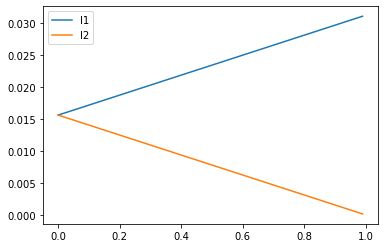

In [86]:
# test stimulus
coherence = np.arange(0., 1., 0.01)
mu0 = 30.
I1, I2 = stimulus(coherence, mu0, 1.)
plt.plot(coherence, I1, label='I1')
plt.plot(coherence, I2, label='I2')
plt.legend()
plt.show()

In [5]:
bp.profile.set(jit=False, dt=.1)

In [136]:
def single_trial(I1, I2, duration=100.):
    model = decision_model()
    neu = bp.NeuGroup(model, 1, monitors=['r1', 'r2'])
    neu.run(duration, inputs=(['ST.input1', I1],['ST.input2', I2]), report=False)

    fig, gs = bp.visualize.get_figure(1, 1, 3, 8)

    fig.add_subplot(gs[0, 0])

    plt.plot(neu.mon.ts, neu.mon.r1[:,0], 'r', label = 'group1')
    plt.plot(neu.mon.ts, neu.mon.r2[:,0], 'b', label = 'group2')
    plt.ylabel('r')
    plt.legend()
    plt.show()

I1 = 0.0156  I2 = 0.0156


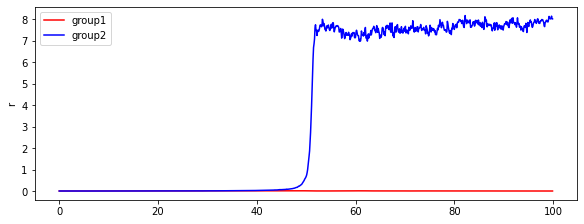

In [143]:
coherence = 0.
mu0 = 30.

I1, I2 = stimulus(coherence, mu0, 1.)
print("I1 =", I1, " I2 =", I2)

single_trial(I1, I2)

When coherence = 0., all the dots are random, thus I1=I2, the choise behavior is also random.

We can see from the phase protrait that whether s1 or s2 would be reach to 1 as attractors, depends on the initial points.

### Phase plane analysis

0.0165984 0.0146016
Fixed point #1 at s1=0.9973266215752016, s2=0.16537066078274795 is a saddle-node.
Fixed point #2 at s1=0.16537997594983117, s2=0.9973266106887477 is a saddle-node.
Fixed point #3 at s1=0.9937225825881328, s2=0.9937225825881328 is a stable-node.
Fixed point #4 at s1=0.9974876222554442, s2=0.0978774721742077 is a stable-node.
Fixed point #5 at s1=0.0978774657598082, s2=0.9974876222718198 is a stable-node.
Fixed point #6 at s1=0.9973976395575831, s2=0.13623688545270718 is a saddle-node.


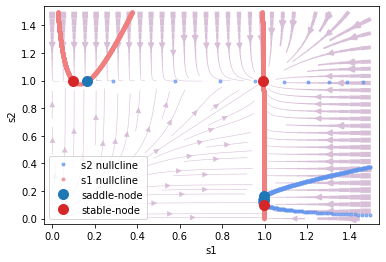

array([[0.99732662, 0.16537066],
       [0.16537998, 0.99732661],
       [0.99372258, 0.99372258],
       [0.99748762, 0.09787747],
       [0.09787747, 0.99748762],
       [0.99739764, 0.13623689]])

In [12]:
coherence=6.4 / 100.
mu0=30.
I1, I2 = stimulus(coherence, mu0, 1.)
print(I1, I2)

analyzer = bp.PhasePortraitAnalyzer(
    model=decision_model(),
    target_vars=OrderedDict(s1=[0., 1.5], s2=[0., 1.5]),
    fixed_vars={'I1': I1, 'I2':I2},
    options={'resolution': 0.001,
            'escape_sympy_solver': True}

)

analyzer.plot_vector_field()
analyzer.plot_nullcline()
analyzer.plot_fixed_point(show=True)

0.033914160000000006 0.01094584


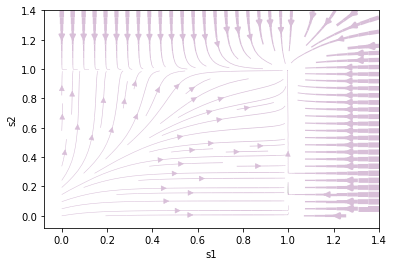

In [32]:
coherence=0.512
mu0=100.
I1, I2 = stimulus(coherence, mu0, 1.)
print(I1, I2)

analyzer = bp.PhasePortraitAnalyzer(
    model=decision_model(),
    target_vars=OrderedDict(s1=[0., 1.5], s2=[0., 1.5]),
    fixed_vars={'I1': I1, 'I2':I2})

analyzer.plot_vector_field(show=True)

0.8999999999999999 0.3


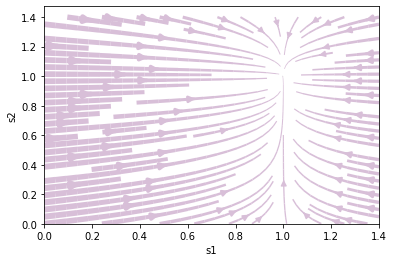

In [42]:
coherence=0.5
mu0=30.
I1, I2 = stimulus(coherence, mu0, 1., JAext = 0.02)
print(I1, I2)

analyzer = bp.PhasePortraitAnalyzer(
    model=decision_model(),
    target_vars=OrderedDict(s1=[0., 1.5], s2=[0., 1.5]),
    fixed_vars={'I1': I1, 'I2':I2})

analyzer.plot_vector_field(show=True)

0.09 0.03


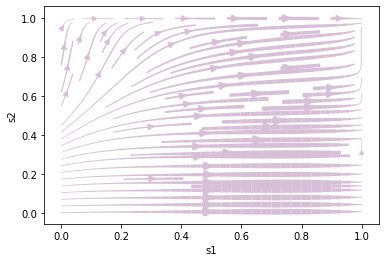

In [41]:
coherence=0.5
mu0=30.
I1, I2 = stimulus(coherence, mu0, 1.,JAext = 0.002)
print(I1, I2)

analyzer = bp.PhasePortraitAnalyzer(
    model=decision_model(),
    target_vars=OrderedDict(s1=[0., 1.1], s2=[0., 1.1]),
    fixed_vars={'I1': I1, 'I2':I2})

analyzer.plot_vector_field(show=True)